In [83]:
import pandas as pd
import pandas_profiling
import os
import pickle
import gc
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

from sklearn.linear_model    import LogisticRegression

#データ読み込み
train = pd.read_csv("data_EDA/train.csv")
test = pd.read_csv("data_EDA/test.csv")

In [84]:
train.head()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BloodPressure_0,SkinThickness_0,Insulin_0,SkinThickness_na,BloodPressure_na,Insulin_na,SkinThickness_mean,BloodPressure_mean,Insulin_mean,Pregnancies_bin
0,200,9,125,74,0,0,28.536910,0.444902,45,1.0,74.0,NaN,NaN,1,0,1,26.875,74.0,135.636364,10
1,3832,4,109,80,0,0,28.047673,0.238243,22,0.0,80.0,NaN,NaN,1,0,1,26.875,80.0,135.636364,6
2,4927,4,88,78,39,0,52.371341,0.279471,26,0.0,78.0,39.0,NaN,0,0,1,39.000,78.0,135.636364,6
3,4088,9,125,74,0,0,40.062688,0.203922,45,0.0,74.0,NaN,NaN,1,0,1,26.875,74.0,135.636364,10
4,3644,5,107,78,44,284,52.935068,0.284959,45,1.0,78.0,44.0,284.0,0,0,0,44.000,78.0,284.000000,6


In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     3000 non-null   int64  
 1   Pregnancies               3000 non-null   int64  
 2   Glucose                   3000 non-null   int64  
 3   BloodPressure             3000 non-null   int64  
 4   SkinThickness             3000 non-null   int64  
 5   Insulin                   3000 non-null   int64  
 6   BMI                       3000 non-null   float64
 7   DiabetesPedigreeFunction  3000 non-null   float64
 8   Age                       3000 non-null   int64  
 9   Outcome                   3000 non-null   float64
 10  BloodPressure_0           2887 non-null   float64
 11  SkinThickness_0           1234 non-null   float64
 12  Insulin_0                 256 non-null    float64
 13  SkinThickness_na          3000 non-null   int64  
 14  BloodPre

In [86]:
train.describe()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BloodPressure_0,SkinThickness_0,Insulin_0,SkinThickness_na,BloodPressure_na,Insulin_na,SkinThickness_mean,BloodPressure_mean,Insulin_mean,Pregnancies_bin
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,2887.000000,1234.000000,256.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,2492.964667,3.557000,113.733667,68.743667,11.164000,11.663333,35.408959,0.400476,28.932000,0.239000,71.434361,27.141005,136.679688,0.588667,0.037667,0.914667,26.984417,71.433414,135.725394,5.594000
std,1447.218078,3.032131,20.885612,16.332755,14.351159,45.064090,6.990180,0.274666,8.469078,0.426544,9.215697,8.182799,82.032125,0.492157,0.190421,0.279424,5.248441,9.040411,23.922032,2.857951
min,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000,7.748040,0.145844,21.000000,0.000000,46.000000,7.000000,15.000000,0.000000,0.000000,0.000000,7.000000,46.000000,15.000000,3.000000
25%,1218.750000,1.000000,100.000000,64.000000,0.000000,0.000000,32.301920,0.230987,22.000000,0.000000,64.000000,19.000000,79.250000,0.000000,0.000000,1.000000,26.875000,64.000000,135.636364,3.000000
50%,2465.500000,3.000000,111.000000,70.000000,0.000000,0.000000,33.835873,0.268674,26.000000,0.000000,70.000000,28.000000,126.000000,1.000000,0.000000,1.000000,26.875000,71.409223,135.636364,6.000000
75%,3750.250000,6.000000,125.000000,78.000000,24.000000,0.000000,39.578256,0.506778,33.000000,0.000000,78.000000,33.000000,180.000000,1.000000,0.000000,1.000000,26.875000,78.000000,135.636364,10.000000
max,4999.000000,13.000000,196.000000,110.000000,49.000000,579.000000,53.400629,2.302072,67.000000,1.000000,110.000000,49.000000,579.000000,1.000000,1.000000,1.000000,49.000000,110.000000,579.000000,10.000000


In [131]:
# まずは少ない特徴量から検討していく
X_train = train[['DiabetesPedigreeFunction',
                 'BMI',
                 'Glucose',
                 'Age',
                 'Pregnancies',
                 'SkinThickness',
                 'BloodPressure',
                 'Insulin',
                 
             ]]
id_train = train[['index']]
y_train = train[['Outcome']]


X_test = test[X_train.columns]
id_test = test[id_train.columns]

In [132]:
# 標準化
change_cloumns = X_train.columns

for col in change_cloumns :
    value_mean = X_train[col].mean()
    value_std = X_train[col].std()
    X_train[col] = (X_train[col] - value_mean) /  value_std
    
for col in change_cloumns :
    value_mean = X_test[col].mean()
    value_std = X_test[col].std()
    X_test[col] = (X_test[col] - value_mean) / value_std

In [133]:
X_train.describe()

,DiabetesPedigreeFunction,BMI,Glucose,Age,Pregnancies,SkinThickness,BloodPressure,Insulin
count,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03
mean,1.598721e-16,-5.796844e-16,1.006602e-16,1.563194e-16,4.618528e-17,1.450691e-17,-1.918465e-16,4.440892e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.270594e-01,-3.957111e+00,-2.716399e+00,-9.365836e-01,-1.173103e+00,-7.779163e-01,-4.208945e+00,-2.588166e-01
25%,-6.170720e-01,-4.444863e-01,-6.575659e-01,-8.185070e-01,-8.433014e-01,-7.779163e-01,-2.904389e-01,-2.588166e-01
50%,-4.798629e-01,-2.250422e-01,-1.308876e-01,-3.462006e-01,-1.836992e-01,-7.779163e-01,7.692109e-02,-2.588166e-01
75%,3.870248e-01,5.964506e-01,5.394304e-01,4.803356e-01,8.057041e-01,8.944226e-01,5.667344e-01,-2.588166e-01
max,6.923302e+00,2.573849e+00,3.938900e+00,4.494940e+00,3.114312e+00,2.636442e+00,2.525987e+00,1.258955e+01


In [134]:
X_test.describe()

,DiabetesPedigreeFunction,BMI,Glucose,Age,Pregnancies,SkinThickness,BloodPressure,Insulin
count,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03
mean,-7.949197e-17,-6.812328e-16,2.584599e-16,-1.922906e-16,-7.993606e-18,-2.620126e-17,3.685940e-16,-8.348877e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.899934e-01,-3.791481e+00,-2.605523e+00,-9.421087e-01,-1.173625e+00,-7.970952e-01,-4.251454e+00,-2.380071e-01
25%,-6.258261e-01,-4.332533e-01,-6.500222e-01,-8.254461e-01,-8.461629e-01,-7.970952e-01,-2.946864e-01,-2.380071e-01
50%,-4.885987e-01,-2.554457e-01,-1.497777e-01,-3.587958e-01,-1.912380e-01,-7.970952e-01,7.626051e-02,-2.380071e-01
75%,3.920019e-01,5.921676e-01,4.868970e-01,4.578423e-01,7.911492e-01,9.281421e-01,5.708564e-01,-2.380071e-01
max,6.643048e+00,2.504541e+00,3.852178e+00,4.424370e+00,3.083386e+00,2.902383e+00,2.549240e+00,1.469388e+01


In [135]:
print(X_train.shape, y_train.shape, id_train.shape)

(3000, 8) (3000, 1) (3000, 1)


ベースライン評価のため一部データを分ける。

残りのデータでvalidationしてその条件・目的変数・validation方法・評価指標を仮定し評価する。

上記3項目を明確にすることをベースラインの決定とする。

validationした後にベースライン評価のためのデータで評価しベースラインを検証する。

validation時とベースライン検証時の結果の傾向に大きな差が無ければベースラインの3項目は問題ないと判断する。

ベースラインが決定すると、その後EDAやモデル改善後はvalidationのみを行い進めていく。
（変更点や結果を記録）

## validation方法（ベースライン作成へ）

clf = RandomForestClassifier(random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_test, y_test))

In [136]:
random_state = 123
params = {'penalty':'l2',          # 正則化項(L1正則化 or L2正則化が選択可能)
          'dual': False,            # Dual or primal
          'tol': 0.0001,            # 計算を停止するための基準値
          'C': 1.0,                 # 正則化の強さ
          'fit_intercept': True,    # バイアス項の計算要否
          'intercept_scaling': 1,   # solver=‘liblinear’の際に有効なスケーリング基準値'
          'class_weight': None,     # クラスに付与された重み
          'random_state': 123,     # 乱数シード
          'solver': 'liblinear',        # ハイパーパラメータ探索アルゴリズム
          'max_iter': 100,          # 最大イテレーション数
          'multi_class': 'auto',    # クラスラベルの分類問題（2値問題の場合'auto'を指定）
          'verbose': 0,             # liblinearおよびlbfgsがsolverに指定されている場合、冗長性のためにverboseを任意の正の数に設定
          'warm_start': False,      # Trueの場合、モデル学習の初期化に前の呼出情報を利用
          'n_jobs': None,           # 学習時に並列して動かすスレッドの数
          'l1_ratio': None          # 正則化パラメータpenalty=’elasticnet’の場合に設定するl1/l2正則化の比率。
         }

#https://qiita.com/FujiedaTaro/items/61ded4ea5643a6204317#

In [137]:
# cvでの評価用
def train_lgr(input_x,
              input_y,
              input_id,
              params,
              list_nfold=[0,1,2,3,4],
              n_splits=5,
              random_state=123
            ):
    train_oof = np.zeros(len(input_x))
    # foldごとの推論値
    metrics = []
    coef = pd.DataFrame()
                         
    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).
              split(input_x, input_y))
    
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print('y_train:{:.3f}, y_tr:{:.3f}, y_va{:.3f}'.
              format(y_train['Outcome'].mean(), y_tr['Outcome'].mean(), y_va['Outcome'].mean(),))

        model = LogisticRegression(**params)
        model.fit(x_tr,
                  y_tr,
                )
        # モデルの保存
        fname_lgr = 'model/lgr/model_lgr_fold{}.pickle'.format(nfold)
        with open(fname_lgr, 'wb')as f:
            pickle.dump(model, f, protocol=4)
            
        # 評価
        y_tr_pred = model.predict_proba(x_tr)[:,1]
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_tr = accuracy_score(y_tr, np.where(y_tr_pred>=0.5,1,0).astype(int))
        metric_va = accuracy_score(y_va, np.where(y_va_pred>=0.5,1,0).astype(int))
        print('[accuracy] tr: {:.2f}, va: {:2f}'.
             format(metric_tr, metric_va))
        metrics.append([nfold, metric_tr, metric_va])
        
        # oof
        train_oof[idx_va] = y_va_pred
        
        # coef

        _coef = pd.DataFrame({'col':input_x.columns, 'imp':model.coef_[0],'nfold':nfold})
        coef = pd.concat([coef, _coef], axis=0, ignore_index=False)
        

    print('-'*20, 'result', '-'*20)
    
    # metrix出力
    metrics = np.array(metrics)
    print(metrics)
    print('[cv] tr: {:.2f}+-{:.2f}, va: {:.2f}'.format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std()
    ))
    print('[oof_acc] {:.4f}'.format(
        accuracy_score(input_y, np.where(train_oof>=0.5,1,0))))
    print('[oof_auc] {:.4f}'.format(
        roc_auc_score(input_y, train_oof)))
    # oof出力  
    train_oof = pd.concat([
        input_id,
        pd.DataFrame({'pred':train_oof})]
        ,axis=1)
    
     # coef出力
    coef = coef.groupby('col')['imp'].agg(['mean', 'std']).reset_index(drop=False)
    coef.columns = ['col', 'coef', 'coef_std']
    

    print('Done')
    
    return train_oof, coef,  metrics

In [138]:
train_oof, coef, metrics = train_lgr(X_train, y_train, id_train, params,list_nfold=[0,1,2,3,4], n_splits=5, random_state=123)

-------------------- 0 --------------------
(2400, 8) (2400, 1)
(600, 8) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.240
[accuracy] tr: 0.78, va: 0.783333
-------------------- 1 --------------------
(2400, 8) (2400, 1)
(600, 8) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.240
[accuracy] tr: 0.78, va: 0.766667
-------------------- 2 --------------------
(2400, 8) (2400, 1)
(600, 8) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.238
[accuracy] tr: 0.78, va: 0.776667
-------------------- 3 --------------------
(2400, 8) (2400, 1)
(600, 8) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.238
[accuracy] tr: 0.77, va: 0.786667
-------------------- 4 --------------------
(2400, 8) (2400, 1)
(600, 8) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.238
[accuracy] tr: 0.78, va: 0.765000
-------------------- result --------------------
[[0.         0.7775     0.78333333]
 [1.         0.77833333 0.76666667]
 [2.         0.77666667 0.77666667]
 [3.         0.77375    0.78666667]
 [4.         0.77833333 0.765     ]]
[cv] 

In [109]:
train_oof

,index,pred
0,200,0.403874
1,3832,0.074312
2,4927,0.410026
3,4088,0.602822
4,3644,0.763905
...,...,...
2995,4931,0.113133
2996,3264,0.061135
2997,1653,0.107075
2998,2607,0.213697


In [130]:
coef.sort_values('coef', ascending=False)

,col,coef,coef_std
1,BMI,0.609684,0.017165
10,SkinThickness_na,0.540201,0.058501
0,Age,0.422841,0.041635
9,SkinThickness,0.384977,0.046159
8,Pregnancies,0.281605,0.010557
4,DiabetesPedigreeFunction,0.174728,0.012683
5,Glucose,0.112077,0.015672
6,Insulin,0.051132,0.050341
7,Insulin_na,0.028381,0.037743
2,BloodPressure,0.027721,0.049247


###

'DiabetesPedigreeFunction', 'BMI', 'Glucose', 'Age', 'Pregnancies',
       'BloodPressure_na', 'BloodPressure_0', 'SkinThickness', 'Insulin_0' 'Insulin_na' 
       
       
'SkinThickness_na' or 'SkinThickness'
###

In [330]:
X_train.columns

Index(['DiabetesPedigreeFunction', 'BMI', 'Glucose', 'Age', 'Pregnancies',
       'Pregnancies_bin', 'BloodPressure_na', 'BloodPressure_0',
       'SkinThickness', 'Insulin_0', 'Insulin_na'],
      dtype='object')

## 推論

In [66]:
def predict_lgr(input_x,
                input_id,
                list_nfold=[0,1,2,3,4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        fname_lgr = 'model/lgr/model_lgr_fold{}.pickle'.format(nfold)
        with open(fname_lgr, 'rb')as f:
            model = pickle.load(f)
        pred[:,nfold] = model.predict_proba(input_x)[:,1]
        
    pred = pd.concat([
        input_id,
        pd.DataFrame({'pred':pred.mean(axis=1)}),], axis=1)
    
    print('Done')
    
    return pred

In [67]:
test_pred_proba = predict_lgr(X_test,
                    id_test,
                    list_nfold=[0,1,2,3,4],
                   )

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done


In [70]:
test_pred_proba[:3]

,index,pred
0,398,0.218771
1,3833,0.151420
2,4836,0.130459


In [71]:
test_pred = test_pred_proba.copy()  
test_pred['pred']=np.where(test_pred['pred'] < 0.5, 0, 1)
test_pred[:3]

,index,pred
0,398,0
1,3833,0
2,4836,0


In [72]:
train_oof[:3]

,index,pred
0,200,0.399783
1,3832,0.074481
2,4927,0.407904


In [73]:
test_pred.to_csv('sub/submission_lgr.csv', index=None, header=False,)

## アンサンブル用データ

In [74]:
import pickle
 
with open('ensamble/lgr_train.pickle', mode='wb') as fo:
    pickle.dump(train_oof, fo)
    
with open('ensamble/lgr_test.pickle', mode='wb') as fo:
    pickle.dump(test_pred_proba, fo)
    

## ベースライン検証

### 初めに検討し問題なければ、その後はスキップ可能

ベースライン（評価指標や検証法、特徴量選択）の評価を行う

① 検証データの評価値とベースライン評価値のギャップが小さいか確認

② 後分類の傾向が似ているか確認

③ 予測値の分布が似ているか確認

上記3点が問題なければ、ベースラインを決定し、EDAやモデル改善を行う。

In [118]:
# 標準化
change_cloumns = X_train.columns

for col in change_cloumns :
    value_mean = X_train[col].mean()
    value_std = X_train[col].std()
    X_train[col] = (X_train[col] - value_mean) /  value_std
    
for col in change_cloumns :
    value_mean = X_test[col].mean()
    value_std = X_test[col].std()
    X_test[col] = (X_test[col] - value_mean) / value_std

In [119]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(X_train,
                                           y_train,
                                           test_size=0.2,
                                           shuffle=True,
                                           stratify=y_train,
                                           random_state=random_state)
print('検証データ: ',x_tr.shape, y_tr.shape)
print('ベースライン検証データ: ',x_va2.shape, y_va2.shape)

x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=random_state)
print('検証データ(train): ',x_tr1.shape, y_tr1.shape)
print('検証データ(test): ',x_va1.shape, y_va1.shape)


検証データ:  (2400, 11) (2400, 1)
ベースライン検証データ:  (600, 11) (600, 1)
検証データ(train):  (1920, 11) (1920, 1)
検証データ(test):  (480, 11) (480, 1)


In [120]:
#validation結果
model = LogisticRegression(**params)
model.fit(x_tr1,
          y_tr1,
         )

LogisticRegression(random_state=123, solver='liblinear')

In [121]:
#評価指標の差
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)
print('[検証データ] acc: {:.4f}'.format(accuracy_score(y_va1, y_va1_pred)))
print('[ベースライン検証データ] acc: {:.4f}'.format(accuracy_score(y_va2, y_va2_pred)))

y_va1_pred_proba = model.predict_proba(x_va1)
y_va2_pred_proba = model.predict_proba(x_va2)
print('[検証データ] auc: {:.4f}'.format(roc_auc_score(y_va1, y_va1_pred_proba[:,1])))
print('[ベースライン検証データ] auc: {:.4f}'.format(roc_auc_score(y_va2, y_va2_pred_proba[:,1])))


[検証データ] acc: 0.7625
[ベースライン検証データ] acc: 0.7683
[検証データ] auc: 0.7039
[ベースライン検証データ] auc: 0.7836


In [122]:
#後分類の分布
print('検証データ')
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize='all'))

print('ベースライン検証データ')
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize='all'))

検証データ
[[344  21]
 [ 93  22]]
[[0.71666667 0.04375   ]
 [0.19375    0.04583333]]
ベースライン検証データ
[[432  25]
 [114  29]]
[[0.72       0.04166667]
 [0.19       0.04833333]]


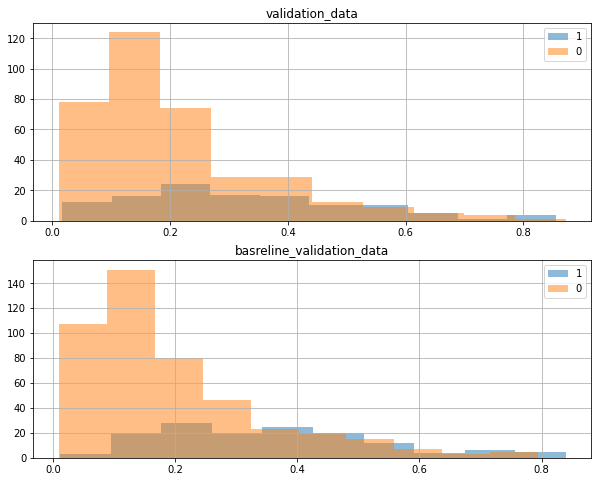

In [123]:
# 予測値の分布
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

fig = plt.figure(figsize=(10,8))

fig.add_subplot(2,1,1)
plt.title('validation_data')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

fig.add_subplot(2,1,2)
plt.title('basreline_validation_data')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()